In [1]:
import sys 
sys.path.append('r/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm')
from flax import nnx
import jax.numpy as jnp
import jax.random as jr
import jax
from jax import vmap
from flax import linen as nn
import matplotlib.pyplot as plt # creating visualizations

## Generate Data

nsamples= 10000


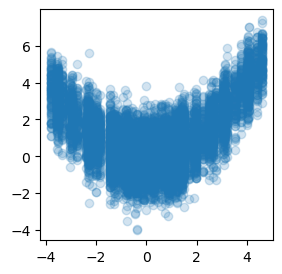

In [2]:
def generate_data_curved(key, n_samples):
  keys = jr.split(key, 2)
  epsilon = jr.normal(keys[0], shape=(n_samples, ))
  x_data = jr.uniform(keys[1], (n_samples, ), minval=-10.5, maxval=10.5)
  y_data = 7*jnp.sin(0.75*x_data) + 0.5*x_data + epsilon
  return jnp.array([x_data, y_data])

def generate_data_nl_gaussian(key, n_samples):
  keys = jr.split(key, 2)
  u  = jr.normal(keys[0], shape=(n_samples, 2))
  x = 2 * u[:, 0]
  y = x ** 2 / 4 + u[:, 1]
  return jnp.array([x, y])

def generate_data_nl_gaussian_one_to_many(key, n_x, n_y_per_x):
  keys = jr.split(jr.PRNGKey(0), n_x+1)
  x = 2 * jr.normal(keys[0], shape=(n_x, ))
  f = lambda x, key: jnp.array([jnp.tile(x, (n_y_per_x, )), x ** 2 / 4 + jr.normal(key, shape=(n_y_per_x, ))]).T
  out = jnp.concatenate(vmap(f)(x, keys[1:]), axis=0)
  return out
  
n_samples = batch_size = 10000 # just use train everything in a batch
data0 = generate_data_nl_gaussian(jr.PRNGKey(0), n_samples).T
n_x = int(0.01 * n_samples)
n_y_per_x = int(n_samples / n_x)
print('nsamples=', n_x * n_y_per_x)
data = generate_data_nl_gaussian_one_to_many(jr.PRNGKey(0), n_x, n_y_per_x)

# plot the original data and the test data
plt.figure(figsize=(3, 3))
plt.scatter(data[:,0], data[:,1], alpha=0.2)
plt.show()

### Conditional MADE dev

In [3]:
from jax import jit
from functools import partial

@partial(jit, static_argnums=(1,2,3,4,5,6))
def create_degrees2(key, din, dhidden, nhidden, dcond=0, random=False, reverse=False):
    """
    Generates a degree for each hidden and input unit. A unit with degree d can only receive input from units with
    degree less than d.
    :param n_inputs: the number of inputs
    :param n_hiddens: a list with the number of hidden units
    :param input_order: the order of the inputs; can be 'random', 'sequential', or an array of an explicit order
    :param mode: the strategy for assigning degrees to hidden nodes: can be 'random' or 'sequential'
    :return: list of degrees
    """

    degrees = []
    keys = jr.split(key, nhidden + 1)

    degrees_cond = jnp.arange(dcond) + 1
    degrees_input = jnp.arange(dcond + 1, dcond + din + 1)
    if random:
        degrees_input = jr.permutation(keys[0], degrees_input, independent=True)
    if reverse:
        degrees_input = degrees_input[::-1]
    degrees_0 = jnp.concatenate([degrees_cond, degrees_input])
    degrees.append(degrees_0)

    min_prev_degree = jnp.max(jnp.array([dcond, 1]))
    for n in range(nhidden):
        degrees_l = jr.randint(keys[n+1], (dhidden, ), min_prev_degree, dcond + din)
        degrees.append(degrees_l)
        min_prev_degree = jnp.min(jnp.array([jnp.min(degrees[-1]), dcond + din - 1]))

    return degrees

@partial(jit, static_argnums=(1))
def create_masks2(degrees, dcond=0):
    """
    Creates the binary masks that make the connectivity autoregressive.
    :param degrees: a list of degrees for every layer
    :return: list of all masks, as theano shared variables
    """

    Ms = []

    for _, (d0, d1) in enumerate(zip(degrees[:-1], degrees[1:])):
        M = d0[:, jnp.newaxis] <= d1
        Ms.append(M.astype(int))

    Mmp = degrees[-1][:, jnp.newaxis] < degrees[0][dcond:]

    return Ms, Mmp.astype(int)

In [62]:
from inference import Linear
from masks import create_masks, create_degrees

# class CONDMADEnet(nnx.Module):
#     def __init__(self, din: int, dcond: int, dhidden: int, nhidden: int, *, rngs: nnx.Rngs, random=False, reverse=False):
#         dout = din
#         self.din, self.dhidden, self.nhidden = din, dhidden, nhidden
#         degrees = create_degrees(rngs.split(), dcond+din, dhidden, nhidden, random=random, reverse=reverse)
#         masks = create_masks(degrees)
#         in_mask = masks[0][0]
#         mid_masks = masks[0][1:]
#         out_mask = masks[1][:, dcond:]
#         self.input_order = degrees[0]
#         # in_mask, mid_masks, final_layer_conexxions = create_masks(din+dcond, dhidden, nhidden, rngs.split())
#         # out_mask = create_out_mask(final_layer_conexxions, dout, dcond).T
#         for i in range(nhidden):
#             if i == 0:
#                 setattr(self, f'linear{i+1}', Linear(in_mask, din + dcond, dhidden, rngs=rngs))  
#                 setattr(self, f'dropout{i+1}', nnx.Dropout(rate=0.2, rngs=rngs))  
#                 setattr(self, f'bn{i+1}', nnx.BatchNorm(dhidden, rngs=rngs))
#             else:
#                 setattr(self, f'linear{i+1}', Linear(mid_masks[i-1], dhidden, dhidden, rngs=rngs))
#                 setattr(self, f'dropout{i+1}', nnx.Dropout(rate=0.2, rngs=rngs))
#                 setattr(self, f'bn{i+1}', nnx.BatchNorm(dhidden, rngs=rngs))
#             self.linear_mu = Linear(out_mask, dhidden, dout, rngs=rngs)
#             self.linear_alpha = Linear(out_mask, dhidden, dout, rngs=rngs)

#     def __call__(self, x: jax.Array):
#         """
#         x is a tensor of shape (batch_size, din + dcond). 
#         """
#         for i in range(self.nhidden):
#             linear = getattr(self, f'linear{i+1}')
#             dropout = getattr(self, f'dropout{i+1}')
#             bn = getattr(self, f'bn{i+1}')
#             x = linear(x)
#             x = bn(x)
#             x = dropout(x)
#             x = nnx.gelu(x)
#         return jnp.stack([self.linear_mu(x), self.linear_alpha(x)], axis=1)

# class CONDMADE(nnx.Module):

#     def __init__(self, din: int, dcond: int, dhidden: int, nhidden: int, *, rngs: nnx.Rngs):
#         self.made_params = CONDMADEnet(din, dcond, dhidden, nhidden, rngs=rngs)
#         self.din = din
#         self.dcond = dcond

#     def __call__(self, x: jax.Array):
#         """
#         Implements the inverse MADE transformation x -> u
#         """
#         assert x.shape[1] == self.din + self.dcond
#         params = self.made_params(x)
#         mus = params[:, 0]
#         alphas = params[:, 1]
#         us = jnp.exp(-alphas) * (x[:, self.dcond:] - mus)
#         return us, jnp.sum(alphas)

#     def generate(self, u, xcond):
#         assert len(u.shape) == 2
#         x = jnp.concatenate([xcond, jnp.zeros(jnp.shape(u))], axis=1)
#         for i in range(self.din):
#             params = self.made_params(x)[:, :, i]
#             new_x = params[:, 0] + jnp.exp(params[:, 1]) * u[:, i]
#             x = x.at[:, self.dcond+i].set(new_x)
#         return x
  
#     def sample(self, key, xcond):
#         num_samples = xcond.shape[0]
#         u = jr.normal(key, (num_samples, self.din))
#         return self.generate(u, xcond)
  
#     def loss_fn(self, x):
#         self.train()
#         us, sum_alphas = self(x)
#         return jnp.sum(us ** 2)/2 + sum_alphas

class CMADEnet(nnx.Module):
    def __init__(self, 
                 din: int,
                 dcond: int, 
                 dhidden: int, 
                 nhidden: int,
                 rngs: nnx.Rngs, 
                 random: bool=False, 
                 reverse: bool=False, 
                 batch_norm: bool=False,
                 dropout: bool=False):
        dout = 2 * din
        self.din, self.dhidden, self.nhidden = din, dhidden, nhidden
        degrees = create_degrees2(rngs.split(), din, dhidden, nhidden, dcond, random, reverse)
        masks = create_masks2(degrees, dcond)
        self.input_order = degrees[0]
        self.layers = []
        for mask in masks[0]:
            d1, d2 = jnp.shape(mask)
            self.layers.append(Linear(mask, d1, d2, rngs=rngs))
            if batch_norm: self.layers.append(nnx.BatchNorm(d2, rngs=rngs))
            if dropout: self.layers.append(nnx.Dropout(rate=0.1, rngs=rngs))
            self.layers.append(nnx.relu)
        out_mask = jnp.concatenate([masks[1], masks[1]], axis=1)
        self.layers.append(Linear(out_mask, dhidden, dout, rngs=rngs))

    def __call__(self, x: jax.Array):
        for layer in self.layers:
            x = layer(x)
        return x.reshape(-1, 2, self.din)
  
class CMADE(nnx.Module):
    def __init__(self, 
                 din: int, 
                 dcond: int,
                 dhidden: int, 
                 nhidden: int,
                 rngs: nnx.Rngs = nnx.Rngs(0), 
                 random: bool=False, 
                 reverse:bool =False,
                 batch_norm: bool=False,
                 dropout: bool=False):
        self.network = CMADEnet(din, dcond, dhidden, nhidden, rngs, random, reverse, batch_norm, dropout)
        self.din = din
        self.dcond = dcond
        self.input_order = self.network.input_order

    def __call__(self, x: jax.Array):
        """
        Implements the inverse MADE transformation x -> u
        A note on the order of the inputs: the made_params call function computes the parameters mu and alpha for the 
        ordering given by the 
        """
        params = self.network(x)
        mus = params[:, 0]
        mus = mus[:, jnp.argsort(self.input_order[self.dcond:])]
        alphas = params[:, 1]
        alphas = alphas[:, jnp.argsort(self.input_order[self.dcond:])]
        x = x[:, self.dcond:]
        us = jnp.exp(-alphas) * (x[:, jnp.argsort(self.input_order[self.dcond:])] - mus)
        return us, jnp.sum(-alphas, axis=1)

    def backward(self, u, x_cond = None):
        assert len(u.shape) == 2
        x = jnp.zeros(jnp.shape(u))
        if x_cond is not None:
            x = jnp.concatenate([x_cond, x], axis=1)
        for i in range(1 + self.dcond, self.dcond + self.din + 1):
            idx = jnp.argwhere(self.input_order == i)[0, 0]
            shift_idx = idx - self.dcond
            params = self.network(x)    
            mus = params[:, 0]
            alphas = params[:, 1]
            alphas = jnp.clip(alphas, a_max=10)
            new_x = mus[:, shift_idx] + jnp.exp(alphas[:, shift_idx]) * u[:, shift_idx-1]
            x = x.at[:, idx].set(new_x)
        return x, None
  
    def generate(self, key, num_samples, cond_samples):
        assert cond_samples.shape[0] == num_samples
        u = jr.normal(key, (num_samples, self.din))
        samples, _ = self.backward(u, cond_samples)
        return samples
    
    def loss_fn(self, x):
        u, log_det = self(x)
        loss = jnp.sum(u ** 2, axis=1)/2
        loss += 0.5 * x.shape[1] * jnp.log(2 * jnp.pi)
        loss -= log_det
        return  jnp.mean(loss)

### Add conditional functionality to create_degrees, masks

In [70]:
din = 5
dcond = 3
made = CMADE(din, dcond, 16, 1, nnx.Rngs(0), random=True)
# made(jnp.ones((10, din + dcond)))
# made.backward(jnp.ones((10, din)), jnp.ones((10, dcond)))[0].shape
made.generate(jr.PRNGKey(0), 10, jnp.ones((10, dcond)))

Array([[ 1.        ,  1.        ,  1.        , -0.15682746, -0.1626422 ,
        -1.2566468 , -1.0835735 ,  0.233354  ],
       [ 1.        ,  1.        ,  1.        ,  0.84636647, -0.6637918 ,
        -0.83857673, -0.09389211, -0.093871  ],
       [ 1.        ,  1.        ,  1.        , -1.3119786 , -0.13996932,
        -0.8127907 ,  0.17226635,  0.67931414],
       [ 1.        ,  1.        ,  1.        ,  0.28142273, -1.7533476 ,
        -0.3159628 ,  1.1246703 ,  0.46870452],
       [ 1.        ,  1.        ,  1.        , -1.9379559 , -0.18936199,
         0.22253609,  1.048394  , -0.22016735],
       [ 1.        ,  1.        ,  1.        , -1.6309695 ,  1.5520251 ,
        -0.5678721 , -0.06087221, -1.3257064 ],
       [ 1.        ,  1.        ,  1.        ,  0.14487027,  0.6150388 ,
         0.40359813, -0.06827925,  0.0736933 ],
       [ 1.        ,  1.        ,  1.        ,  0.33667687,  0.31015688,
        -0.09980434,  0.96597356,  2.1226203 ],
       [ 1.        ,  1.        

In [8]:
jnp.argsort(jnp.array([9, 7, 8, 2]))

Array([3, 1, 2, 0], dtype=int32)

In [6]:
from inference import MADEnet

net = MADEnet(din, 16, 1, rngs=nnx.Rngs(jr.PRNGKey(0)))
x = jr.normal(jr.PRNGKey(0), (10, din))
net(x)

(10, 3)
(10, 16)
(10, 16)


Array([[[ 0.0000000e+00,  5.8231654e-04,  2.5518213e-03],
        [ 0.0000000e+00, -8.5169086e-03,  3.9954237e-03]],

       [[ 0.0000000e+00, -9.5245145e-02,  2.4677306e-02],
        [ 0.0000000e+00, -2.4756625e-01, -1.4383921e-01]],

       [[ 0.0000000e+00,  8.7552948e-04, -3.4319934e-02],
        [ 0.0000000e+00, -1.2805414e-02,  2.7280098e-03]],

       [[ 0.0000000e+00, -1.0304499e-03, -2.1526930e-01],
        [ 0.0000000e+00, -2.6784006e-03, -1.4187276e-01]],

       [[ 0.0000000e+00, -6.1473005e-02,  1.8673327e-03],
        [ 0.0000000e+00, -1.5978393e-01, -9.1675051e-02]],

       [[ 0.0000000e+00, -8.1401570e-03, -3.6778636e-02],
        [ 0.0000000e+00, -2.1158332e-02, -2.3314446e-02]],

       [[ 0.0000000e+00, -1.6473992e-02, -1.4167711e-01],
        [ 0.0000000e+00, -4.2820085e-02, -7.9923168e-02]],

       [[ 0.0000000e+00, -9.4386060e-03,  7.4242331e-02],
        [ 0.0000000e+00, -2.4533331e-02, -3.6808968e-02]],

       [[ 0.0000000e+00,  2.2115742e-03, -3.8680032e-01]

In [92]:
cmade = CMADE(3, 1, 64, 3, nnx.Rngs(jr.PRNGKey(1)), True, False)
# cmade(jnp.array([[10.0, 1., 2.]]))
params = cmade.network(jnp.array([jnp.arange(4), jnp.zeros(4), jnp.ones(4), [-2.0, 10.0, 1., 2.]]))
# print(params.shape)
# print(params)
print(cmade.input_order)
mus = params[:, 0]
print(mus) 

[2 4 1 3]
[[ 0.02467592  0.01322097 -0.04885601]
 [ 0.          0.          0.        ]
 [ 0.01233796  0.00865342 -0.01879527]
 [ 0.01233796  0.0128491  -0.02819266]]


In [87]:
print(cmade.input_order)
ids = jnp.argsort(cmade.input_order)[1:]
jnp.arange(4)[ids]

[2 4 1 3]


Array([0, 3, 1], dtype=int32)

### Define optimizer and loss function

In [4]:
import optax

# MLP contains 2 Linear layers, 1 Dropout layer, 1 BatchNorm layer
model = CONDMADE(1, 1, 16, 5, rngs=nnx.Rngs(0))
learning_rate = 1e-2
momentum = 0.9
optimizer = nnx.Optimizer(model, optax.adamw(learning_rate, momentum))

@nnx.jit  # automatic state management
def train_step(model, optimizer, data):
  loss_fn = lambda model: model.loss_fn(data)
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # inplace updates
  return loss

losses = []
for i in range(3000):
  loss = train_step(model, optimizer, data)
  losses.append(loss)
  if i % 100 == 0:
    print(f'Iteration {i}, Loss {loss}')

Iteration 0, Loss 175229.421875
Iteration 100, Loss 10341.583984375
Iteration 200, Loss 7651.091796875
Iteration 300, Loss 6449.85986328125
Iteration 400, Loss 5971.2890625
Iteration 500, Loss 5829.541015625
Iteration 600, Loss 5767.626953125
Iteration 700, Loss 5711.41015625
Iteration 800, Loss 5658.81396484375
Iteration 900, Loss 5561.49169921875
Iteration 1000, Loss 5545.4482421875
Iteration 1100, Loss 5546.04296875
Iteration 1200, Loss 5574.11474609375
Iteration 1300, Loss 5463.92236328125
Iteration 1400, Loss 5430.658203125
Iteration 1500, Loss 5501.96923828125
Iteration 1600, Loss 5390.744140625
Iteration 1700, Loss 5460.66455078125
Iteration 1800, Loss 5432.89892578125
Iteration 1900, Loss 5433.9833984375
Iteration 2000, Loss 5399.20458984375
Iteration 2100, Loss 5443.275390625
Iteration 2200, Loss 5407.31103515625
Iteration 2300, Loss 5392.7783203125
Iteration 2400, Loss 5426.9375
Iteration 2500, Loss 5413.18701171875
Iteration 2600, Loss 5417.50732421875
Iteration 2700, Loss 5

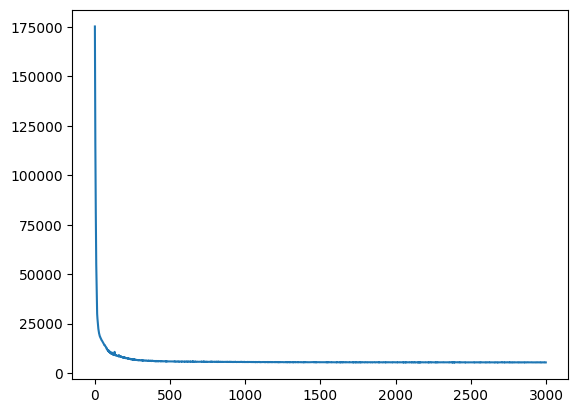

In [5]:
plt.plot(losses)
plt.show()

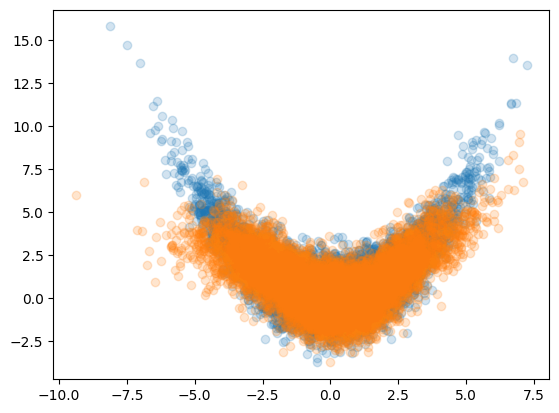

In [9]:
model.eval()
num_samples = 10000
key, subkey = jr.split(jr.PRNGKey(0))
# xcond = jr.uniform(key, (n_samples, 1), minval=-10.5, maxval=10.5)
xcond= 2 * jr.normal(key, shape=(n_samples, 1))
samples = model.sample(subkey, xcond)
plt.scatter(data0[:, 0], data0[:, 1], alpha=0.2)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.2)
plt.show()

## Debugging